# <center>HousePricesRegressor </center>
<img src= "https://miro.medium.com/max/402/1*2foyXif7hwkO8wWB5T9KtQ.png" height="200" align="center"/>

<a id="Table-Of-Contents"></a>
# Table Of Contents
* [Table Of Contents](#Table-Of-Contents)
* [Introduction](#Introduction)
* [Importing Libraries](#Importing-Libraries)
* [Task Details](#Task-Details)
* [Feature Description](#Feature-Description)
* [Read in Data](#Read-in-Data)
    - [Training Data](#Training-Data)
    - [Test Data](#Test-Data)
* [Preprocessing Data](#Preprocessing-Data)
    - [Label Encoding](#Label-Encoding)
    - [Train-Test Split](#Train-Test-Split)
* [Initial Models](#Initial-Models)
* [LightGBM Regressor](#LightGBM-Regressor)
    - [Bayesian Optimization](#Bayesian-Optimization)
    - [Tuning LightGBM](#Tuning-LightGBM)
    - [Feature Importance](#Feature-Importance)
    - [Cross Validation](#Cross-Validation)
* [Prediction for Test Data](#Prediction-for-Test-Data)
* [Conclusion](#Conclusion)

<a id="Introduction"></a>
# Introduction 
This notebook goes through various machine learning techniques for regression. The main focus will be hyper-tuning LightGBM using bayesian optimization. This is a beginner-level notebook but I believe you will find it still useful to read and look over. Please leave comments on where I can improve and give a like! Thank you!

<a id="Importing-Libraries"></a>
# Importing Libraries

In [1]:
#%% Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm

# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')

<a id="Task-Details"></a>
# Task Detail 

## Goal
It is your job to predict the sales price for each house. For each Id in the test set, you must predict the value of the SalePrice variable. 

## Metric
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

<a id="Feature-Description"></a>
# Feature Description 
Here's a brief version of what you'll find in the data description file.

## Target  
SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.  

## Features
MSSubClass: The building class  
MSZoning: The general zoning classification  
LotFrontage: Linear feet of street connected to property  
LotArea: Lot size in square feet  
Street: Type of road access  
Alley: Type of alley access  
LotShape: General shape of property  
LandContour: Flatness of the property  
Utilities: Type of utilities available  
LotConfig: Lot configuration  
LandSlope: Slope of property  
Neighborhood: Physical locations within Ames city limits  
Condition1: Proximity to main road or railroad  
Condition2: Proximity to main road or railroad (if a second is present)  
BldgType: Type of dwelling  
HouseStyle: Style of dwelling  
OverallQual: Overall material and finish quality  
OverallCond: Overall condition rating  
YearBuilt: Original construction date  
YearRemodAdd: Remodel date  
RoofStyle: Type of roof  
RoofMatl: Roof material  
Exterior1st: Exterior covering on house  
Exterior2nd: Exterior covering on house (if more than one material)  
MasVnrType: Masonry veneer type  
MasVnrArea: Masonry veneer area in square feet  
ExterQual: Exterior material quality  
ExterCond: Present condition of the material on the exterior  
Foundation: Type of foundation  
BsmtQual: Height of the basement  
BsmtCond: General condition of the basement  
BsmtExposure: Walkout or garden level basement walls  
BsmtFinType1: Quality of basement finished area  
BsmtFinSF1: Type 1 finished square feet  
BsmtFinType2: Quality of second finished area (if present)  
BsmtFinSF2: Type 2 finished square feet  
BsmtUnfSF: Unfinished square feet of basement area  
TotalBsmtSF: Total square feet of basement area  
Heating: Type of heating  
HeatingQC: Heating quality and condition  
CentralAir: Central air conditioning  
Electrical: Electrical system  
1stFlrSF: First Floor square feet  
2ndFlrSF: Second floor square feet  
LowQualFinSF: Low quality finished square feet (all floors)  
GrLivArea: Above grade (ground) living area square feet  
BsmtFullBath: Basement full bathrooms  
BsmtHalfBath: Basement half bathrooms  
FullBath: Full bathrooms above grade  
HalfBath: Half baths above grade  
Bedroom: Number of bedrooms above basement level  
Kitchen: Number of kitchens  
KitchenQual: Kitchen quality  
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)  
Functional: Home functionality rating  
Fireplaces: Number of fireplaces  
FireplaceQu: Fireplace quality  
GarageType: Garage location  
GarageYrBlt: Year garage was built  
GarageFinish: Interior finish of the garage  
GarageCars: Size of garage in car capacity  
GarageArea: Size of garage in square feet  
GarageQual: Garage quality  
GarageCond: Garage condition  
PavedDrive: Paved driveway  
WoodDeckSF: Wood deck area in square feet  
OpenPorchSF: Open porch area in square feet  
EnclosedPorch: Enclosed porch area in square feet  
3SsnPorch: Three season porch area in square feet  
ScreenPorch: Screen porch area in square feet  
PoolArea: Pool area in square feet  
PoolQC: Pool quality  
Fence: Fence quality  
MiscFeature: Miscellaneous feature not covered in other categories  
MiscVal: $Value of miscellaneous feature  
MoSold: Month Sold  
YrSold: Year Sold  
SaleType: Type of sale  
SaleCondition: Condition of sale  

<a id="Read-in-Data"></a>
# Read in Data

<a id="Training-Data"></a>
## Training Data

In [2]:
#%% Read train.csv
train_csv = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')

# Initial glance at train.csv
print(train_csv.info(verbose = True,null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [3]:
# Check for missing or NaN data in train.csv
pd.set_option("display.max_rows", None, "display.max_columns", None)
print('Feature      Number of NaN')
print(train_csv.isnull().sum().sort_values(ascending=False).loc[lambda x : x!=0])

Feature      Number of NaN
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageCond        81
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64


<a id="Test-Data"></a>
## Test Data

In [4]:
#%% Read test.csv
test_csv = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

# Initial glance at data
print(test_csv.info(verbose = True,null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [5]:
# Check for missing or NaN data in test.csv
pd.set_option("display.max_rows", None, "display.max_columns", None)
print('Feature      Number of NaN')
print(test_csv.isnull().sum().sort_values(ascending=False).loc[lambda x : x!=0])

Feature      Number of NaN
PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageQual        78
GarageYrBlt       78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtQual          44
BsmtExposure      44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtHalfBath       2
Utilities          2
Functional         2
BsmtFullBath       2
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
BsmtUnfSF          1
TotalBsmtSF        1
SaleType           1
Exterior1st        1
KitchenQual        1
GarageArea         1
GarageCars         1
dtype: int64


<a id="Preprocessing-Data"></a>
# Preprocessing Data
We see that the both train.csv and test.csv have missing data. The features ['PoolQC', 'MiscFeature', 'Alley'] should be dropped due to having more than 90% missing values. We will preprocess the dataset by imputation and removing columns with high missing values. 

In [6]:
## return columns with more than num_percent % or more missing values 
def findMissing(df , num_percent = 0.9):
    len_df = len(df)
    amt_missing = len_df * num_percent
    missing_columns = (df.isnull().sum().sort_values(ascending=False).loc[lambda x : x > amt_missing]).index.to_list()
    missing_columns_count = [df[missing_column].isnull().sum() for missing_column in missing_columns]
    missing_columns_percent = [f"{round(df[missing_column].isnull().sum()/len_df,4)*100}%" for missing_column in missing_columns]
    missing_columns_type = [df[missing_column].dtypes for missing_column in missing_columns]
    print(missing_columns_count)
    print(missing_columns_percent)
    print(missing_columns_type)
    return missing_columns

print(findMissing(train_csv))

[1453, 1406, 1369]
['99.52%', '96.3%', '93.77%']
[dtype('O'), dtype('O'), dtype('O')]
['PoolQC', 'MiscFeature', 'Alley']


In [7]:
# columns to be drop in train.csv and test.csv due to having 90% or more missing values 
drop_columns = (train_csv.isnull().sum().sort_values(ascending=False).loc[lambda x : x > .90*1460]).index.to_list()
drop_columns.append('Id')

# save the 'Id' for Train and Test 
train_Id = train_csv['Id'].to_list()
test_Id = test_csv['Id'].to_list()

print('Feature      Number of NaN')
print(test_csv.isnull().sum().sort_values(ascending=False).loc[lambda x : x > .90*1460])

Feature      Number of NaN
PoolQC         1456
MiscFeature    1408
Alley          1352
dtype: int64


For features/columns that have low missing values, less than 10% of each indidiual dataset, we can impute using median imputation for numerical values and mode imputation for categorical values. 

In [8]:
# mode imputation on categorical features 
# median imputation on numeric features
train_clean = train_csv.drop(drop_columns, axis = 'columns', errors = 'ignore')
test_clean = test_csv.drop(drop_columns, axis = 'columns', errors = 'ignore')

train_10_percent_missing_features = train_clean.isnull().sum().sort_values(ascending=False).loc[lambda x : (x<.10*1460)  & (x != 0)].index.to_list()
train_10_percent_missing_features_cat = train_clean[train_10_percent_missing_features].select_dtypes('object').columns.to_list()
train_10_percent_missing_features_num = train_clean[train_10_percent_missing_features].select_dtypes('number').columns.to_list()

train_clean[train_10_percent_missing_features_cat] = train_clean[train_10_percent_missing_features_cat].fillna(train_clean[train_10_percent_missing_features_cat].mode().iloc[0])
train_clean[train_10_percent_missing_features_num] = train_clean[train_10_percent_missing_features_num].fillna(train_clean[train_10_percent_missing_features_num].median().iloc[0])


test_10_percent_missing_features = test_clean.isnull().sum().sort_values(ascending=False).loc[lambda x : (x<.10*1460)  & (x != 0)].index.to_list()
test_10_percent_missing_features_cat = test_clean[test_10_percent_missing_features].select_dtypes('object').columns.to_list()
test_10_percent_missing_features_num = test_clean[test_10_percent_missing_features].select_dtypes('number').columns.to_list()

test_clean[test_10_percent_missing_features_cat] = test_clean[test_10_percent_missing_features_cat].fillna(test_clean[test_10_percent_missing_features_cat].mode().iloc[0])
test_clean[test_10_percent_missing_features_num] = test_clean[test_10_percent_missing_features_num].fillna(test_clean[test_10_percent_missing_features_num].median().iloc[0])

#LotFrontage is a numeric feature and needs to be imputed as well. We can use median imputation again. 

train_clean["LotFrontage"] = train_clean["LotFrontage"].fillna(train_clean["LotFrontage"].median())
test_clean["LotFrontage"] = test_clean["LotFrontage"].fillna(test_clean["LotFrontage"].median())

print("train_clean")
print('Feature      Number of NaN')
print(train_clean.isnull().sum().sort_values(ascending=False).loc[lambda x : x!=0])

print('\n')

print("test_clean")
print('Feature      Number of NaN')
print(test_clean.isnull().sum().sort_values(ascending=False).loc[lambda x : x!=0])

train_clean
Feature      Number of NaN
Fence          1179
FireplaceQu     690
dtype: int64


test_clean
Feature      Number of NaN
Fence          1169
FireplaceQu     730
dtype: int64


For the rest of the features we can use just use NaN as a categorical feature. This will be done in MultiColumnLabelEncoder

In [9]:
# Seperate train_clean into target and features 
y = train_clean['SalePrice']
X_train_clean = train_clean.drop('SalePrice',axis = 'columns')

# save the index for X_aug_train 
X_train_clean_index = X_train_clean.index.to_list()

# row bind aug_train features with aug_test features 
# this makes it easier to apply label encoding onto the entire dataset 
X_total = X_train_clean.append(test_clean,ignore_index = True)
display(X_total.info(verbose = True,null_counts=True))

# save the index for X_aug_test 
X_test_clean_index = np.setdiff1d(X_total.index.to_list() ,X_train_clean_index) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2919 non-null   object 
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2919 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

None

<a id="Label-Encoding"></a>
# Label Encoding

In [10]:
#%% MultiColumnLabelEncoder
# Code snipet found on Stack Exchange 
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
from sklearn.preprocessing import LabelEncoder


class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                # convert float NaN --> string NaN
                output[col] = output[col].fillna('NaN')
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# store the catagorical features names as a list      
cat_features = X_total.select_dtypes(['object']).columns.to_list()

# use MultiColumnLabelEncoder to apply LabelEncoding on cat_features 
# uses NaN as a value , no imputation will be used for missing data
X_total_encoded = MultiColumnLabelEncoder(columns = cat_features).fit_transform(X_total)

In [11]:
##% Split X_total_encoded 
X_train_clean_encoded = X_total_encoded.iloc[X_train_clean_index, :]
X_test_clean_encoded = X_total_encoded.iloc[X_test_clean_index, :].reset_index(drop = True) 
X_train_clean_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 0 to 1459
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   int64  
 2   LotFrontage    1460 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   int64  
 5   LotShape       1460 non-null   int64  
 6   LandContour    1460 non-null   int64  
 7   Utilities      1460 non-null   int64  
 8   LotConfig      1460 non-null   int64  
 9   LandSlope      1460 non-null   int64  
 10  Neighborhood   1460 non-null   int64  
 11  Condition1     1460 non-null   int64  
 12  Condition2     1460 non-null   int64  
 13  BldgType       1460 non-null   int64  
 14  HouseStyle     1460 non-null   int64  
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [12]:
##% Before and After LabelEncoding for train.csv 
display(X_train_clean.head())
display(X_train_clean_encoded.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,0,12,2008,WD,Normal


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,3,65.0,8450,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.0,2,4,2,2,3,3,2,706.0,5,0.0,150.0,856.0,1,0,1,4,856,854,0,1710,1.0,0.0,2,1,3,1,2,8,6,0,3,1,2003.0,1,2.0,548.0,4,4,2,0,61,0,0,0,0,4,0,2,2008,8,4
1,20,3,80.0,9600,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.0,3,4,1,2,3,1,0,978.0,5,0.0,284.0,1262.0,1,0,1,4,1262,0,0,1262,0.0,1.0,2,0,3,1,3,6,6,1,5,1,1976.0,1,2.0,460.0,4,4,2,298,0,0,0,0,0,4,0,5,2007,8,4
2,60,3,68.0,11250,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.0,2,4,2,2,3,2,2,486.0,5,0.0,434.0,920.0,1,0,1,4,920,866,0,1786,1.0,0.0,2,1,3,1,2,6,6,1,5,1,2001.0,1,2.0,608.0,4,4,2,0,42,0,0,0,0,4,0,9,2008,8,4
3,70,3,60.0,9550,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.0,3,4,0,3,1,3,0,216.0,5,0.0,540.0,756.0,1,2,1,4,961,756,0,1717,1.0,0.0,1,0,3,1,2,7,6,1,2,5,1998.0,2,3.0,642.0,4,4,2,0,35,272,0,0,0,4,0,2,2006,8,0
4,60,3,84.0,14260,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.0,2,4,2,2,3,0,2,655.0,5,0.0,490.0,1145.0,1,0,1,4,1145,1053,0,2198,1.0,0.0,2,1,4,1,2,9,6,1,5,1,2000.0,1,3.0,836.0,4,4,2,192,84,0,0,0,0,4,0,12,2008,8,4


In [13]:
##% Before and After LabelEncoding for test.csv 
display(test_clean.head())
display(X_test_clean_encoded.head())

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,MnPrv,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,MnPrv,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,0,1,2010,WD,Normal


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2,80.0,11622,1,3,3,0,4,0,12,1,2,0,2,5,6,1961,1961,1,1,12,13,2,0.0,3,4,1,3,3,3,4,468.0,3,144.0,270.0,882.0,1,4,1,4,896,0,0,896,0.0,0.0,1,0,2,1,3,5,6,0,3,1,1961.0,2,1.0,730.0,4,4,2,140,0,0,0,120,0,2,0,6,2010,8,4
1,20,3,81.0,14267,1,0,3,0,0,0,12,2,2,0,2,6,6,1958,1958,3,1,13,14,1,108.0,3,4,1,3,3,3,0,923.0,5,0.0,406.0,1329.0,1,4,1,4,1329,0,0,1329,0.0,0.0,1,1,3,1,2,6,6,0,3,1,1958.0,2,1.0,312.0,4,4,2,393,36,0,0,0,0,4,12500,6,2010,8,4
2,60,3,74.0,13830,1,0,3,0,4,0,8,2,2,0,5,5,5,1997,1998,1,1,12,13,2,0.0,3,4,2,2,3,3,2,791.0,5,0.0,137.0,928.0,1,2,1,4,928,701,0,1629,0.0,0.0,2,1,3,1,3,6,6,1,5,1,1997.0,0,2.0,482.0,4,4,2,212,34,0,0,0,0,2,0,3,2010,8,4
3,60,3,78.0,9978,1,0,3,0,4,0,8,2,2,0,5,6,6,1998,1998,1,1,12,13,1,20.0,3,4,2,3,3,3,2,602.0,5,0.0,324.0,926.0,1,0,1,4,926,678,0,1604,0.0,0.0,2,1,3,1,2,7,6,1,2,1,1998.0,0,2.0,470.0,4,4,2,360,36,0,0,0,0,4,0,6,2010,8,4
4,120,3,43.0,5005,1,0,1,0,4,0,22,2,2,4,2,8,5,1992,1992,1,1,6,6,2,0.0,2,4,2,2,3,3,0,263.0,5,0.0,1017.0,1280.0,1,0,1,4,1280,0,0,1280,0.0,0.0,2,0,2,1,2,5,6,0,3,1,1992.0,1,2.0,506.0,4,4,2,0,82,0,0,144,0,4,0,1,2010,8,4


<a id="#Train-Test-Split"></a>
# Train-Test Split

In [14]:
# Create test and train set 80-20
#%%  train-test split using a 80-20 split
train_X, valid_X, train_y, valid_y = train_test_split(X_train_clean_encoded, y, test_size=0.2, shuffle = True, random_state=0)

train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1168 entries, 618 to 684
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1168 non-null   int64  
 1   MSZoning       1168 non-null   int64  
 2   LotFrontage    1168 non-null   float64
 3   LotArea        1168 non-null   int64  
 4   Street         1168 non-null   int64  
 5   LotShape       1168 non-null   int64  
 6   LandContour    1168 non-null   int64  
 7   Utilities      1168 non-null   int64  
 8   LotConfig      1168 non-null   int64  
 9   LandSlope      1168 non-null   int64  
 10  Neighborhood   1168 non-null   int64  
 11  Condition1     1168 non-null   int64  
 12  Condition2     1168 non-null   int64  
 13  BldgType       1168 non-null   int64  
 14  HouseStyle     1168 non-null   int64  
 15  OverallQual    1168 non-null   int64  
 16  OverallCond    1168 non-null   int64  
 17  YearBuilt      1168 non-null   int64  
 18  YearRem


# Initial Models
We can not apply different machine learning algorthims to test which model perform better on this dataset. I've listed below various machine learning techniques applied in this section.
 
1. RandomForest
2. Support Vector Machine
3. XGBoost
4. LightGBM

In [15]:
##% evaluateRegressor
# from sklearn.metrics import mean_squared_error, mean_absolute_error
def evaluateRegressor(true,predicted,message = "Test set"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    LogRMSE = mean_squared_error(np.log(true),np.log(predicted),squared = False)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print("LogRMSE:", LogRMSE)

In [16]:
##% Plot True vs predicted values. Useful for continuous y 
def PlotPrediction(true,predicted, title = "Dataset: "):
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(111)
    ax1.set_title(title + 'True vs Predicted')
    ax1.scatter(list(range(0,len(true))),true, s=10, c='r', marker="o", label='True')
    ax1.scatter(list(range(0,len(predicted))), predicted, s=10, c='b', marker="o", label='Predicted')
    plt.legend(loc='upper right');
    plt.show()

In [17]:
##% Initial Models
# from sklearn.ensemble import RandomForestRegressor
# from sklearn import svm
# import lightgbm as lgb
# import xgboost as xg 

RFReg = RandomForestRegressor(random_state = 0).fit(train_X, train_y)
SVM = svm.SVR().fit(train_X, train_y) 
XGReg = xg.XGBRegressor(objective ='reg:squarederror', seed = 0,verbosity=0).fit(train_X,train_y) 
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(train_X,train_y)

In [18]:
##% Model Metrics
print("Random Forest Regressor") 
predicted_train_y = RFReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = RFReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
print("\n")
    
print("Support Vector Machine") 
predicted_train_y = SVM.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = SVM.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
print("\n")


print("XGBoost Regressor") 
predicted_train_y = XGReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = XGReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
print("\n")

print("LightGBM Regressor") 
predicted_train_y = LGBMReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = LGBMReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")

Random Forest Regressor
    Training Set
MSE: 124458317.90507004
MAE: 6553.9395547945205
RMSE: 11156.088826513978
LogRMSE: 0.06263755839008012
    Test Set
MSE: 1069955990.5817266
MAE: 17148.310719178084
RMSE: 32710.181757087907
LogRMSE: 0.1387003405605433


Support Vector Machine
    Training Set
MSE: 6472139002.468355
MAE: 55516.23203243733
RMSE: 80449.60535930774
LogRMSE: 0.4023290326424375
    Test Set
MSE: 7241308930.447164
MAE: 55542.95134930656
RMSE: 85095.88080775217
LogRMSE: 0.38983624335105826


XGBoost Regressor
    Training Set
MSE: 1146598.1193553323
MAE: 733.3596325181935
RMSE: 1070.7932196999252
LogRMSE: 0.00719356555765195
    Test Set
MSE: 1033421355.0116786
MAE: 17563.705586472603
RMSE: 32146.871620916376
LogRMSE: 0.1360696552014993


LightGBM Regressor
    Training Set
MSE: 126288500.57971074
MAE: 5013.819061606673
RMSE: 11237.815649836526
LogRMSE: 0.04809269887204899
    Test Set
MSE: 999264659.8651305
MAE: 16598.163380637183
RMSE: 31611.147715088275
LogRMSE: 0.1355

These models perform poorly as we conduct no parameter tuning. We see lightGBM performs the best on the test set. I use Bayesian Optimization to tune the hyperparameters for LightGBM to obtain a better model. 

<a id="LightGBM-Regressor"></a>
# LightGBM Regressor

<a id="Bayesian-Optimization"></a>
## Bayesian Optimization

In [19]:
##% parameter tuning for lightgbm 
# store the catagorical features names as a list      
cat_features = X_train_clean_encoded.select_dtypes(['object']).columns.to_list()

# Create the LightGBM data containers
# Make sure that cat_features are used
train_data=lgb.Dataset(train_X,label=train_y, categorical_feature = cat_features,free_raw_data=False)
valid_data=lgb.Dataset(valid_X,label=valid_y, categorical_feature = cat_features,free_raw_data=False)

In [20]:
# https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9
# from lightgbm import LGBMRegressor 
# from bayes_opt import BayesianOptimization
def search_best_param(X,y,cat_features):
    
    trainXY = lgb.Dataset(data=X, label=y,categorical_feature = cat_features,free_raw_data=False)
    # define the lightGBM cross validation
    def lightGBM_CV(max_depth, num_leaves, n_estimators, learning_rate, subsample, colsample_bytree, 
                lambda_l1, lambda_l2, min_child_weight):
    
        params = {'boosting_type': 'gbdt', 'objective': 'regression', 'metric':'rmse', 'verbose': -1,
                  'early_stopping_round':100}
        
        params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = int(round(num_leaves))
        params["n_estimators"] = int(round(n_estimators))
        params['learning_rate'] = learning_rate
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_child_weight'] = min_child_weight
    
        score = lgb.cv(params, trainXY, nfold=5, seed=1, stratified=False, verbose_eval =False, metrics=['rmse'])

        return -np.min(score['rmse-mean']) # return negative rmse to minimize rmse 

    # use bayesian optimization to search for the best hyper-parameter combination
    lightGBM_Bo = BayesianOptimization(lightGBM_CV, 
                                       {
                                          'max_depth': (5, 50),
                                          'num_leaves': (20, 100),
                                          'n_estimators': (50, 1000),
                                          'learning_rate': (0.01, 0.3),
                                          'subsample': (0.7, 0.8),
                                          'colsample_bytree' :(0.5, 0.99),
                                          'lambda_l1': (0, 5),
                                          'lambda_l2': (0, 3),
                                          'min_child_weight': (2, 50) 
                                      },
                                       random_state = 1,
                                       verbose = 0
                                      )
    np.random.seed(1)
    
    lightGBM_Bo.maximize(init_points=5, n_iter=25) 
    
    params_set = lightGBM_Bo.max['params']
    
    # get the params of the maximum target     
    max_target = -np.inf
    for i in lightGBM_Bo.res: # loop thru all the residuals 
        if i['target'] > max_target:
            params_set = i['params']
            max_target = i['target']
    
    params_set.update({'verbose': -1})
    params_set.update({'metric': 'rmse'})
    params_set.update({'boosting_type': 'gbdt'})
    params_set.update({'objective': 'regression'})
    
    params_set['max_depth'] = int(round(params_set['max_depth']))
    params_set['num_leaves'] = int(round(params_set['num_leaves']))
    params_set['n_estimators'] = int(round(params_set['n_estimators']))
    params_set['seed'] = 1 #set seed
    
    return params_set

best_params = search_best_param(train_X,train_y,cat_features)

In [21]:
# Print best_params
for key, value in best_params.items():
    print(key, ' : ', value)

colsample_bytree  :  0.7640201996616449
lambda_l1  :  2.095972572016474
lambda_l2  :  2.0556585011902784
learning_rate  :  0.06929115242214005
max_depth  :  45
min_child_weight  :  3.314604473500456
n_estimators  :  687
num_leaves  :  53
subsample  :  0.7558689828445752
verbose  :  -1
metric  :  rmse
boosting_type  :  gbdt
objective  :  regression
seed  :  1


<a id="Tuning-LightGBM"></a>
## Tuning LightGBM

In [22]:
# Train lgbm_best using the best params found from Bayesian Optimization
lgbm_best = lgb.train(best_params,
                 train_data,
                 num_boost_round = 2500,
                 valid_sets = valid_data,
                 early_stopping_rounds = 200,
                 verbose_eval = 100
                 )


Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 32378.7
[200]	valid_0's rmse: 31536.8
[300]	valid_0's rmse: 30597.5
[400]	valid_0's rmse: 29948.8
[500]	valid_0's rmse: 29428
[600]	valid_0's rmse: 29052.3
Did not meet early stopping. Best iteration is:
[687]	valid_0's rmse: 28741.9


<a id="LightGBM-Model-Peformance "></a>
## LightGBM Model Peformance 

LightGBM Regressor Tuned
    Training Set
MSE: 11554234.22433426
MAE: 656.1020378047688
RMSE: 3399.151986059797
LogRMSE: 0.013722985821368874


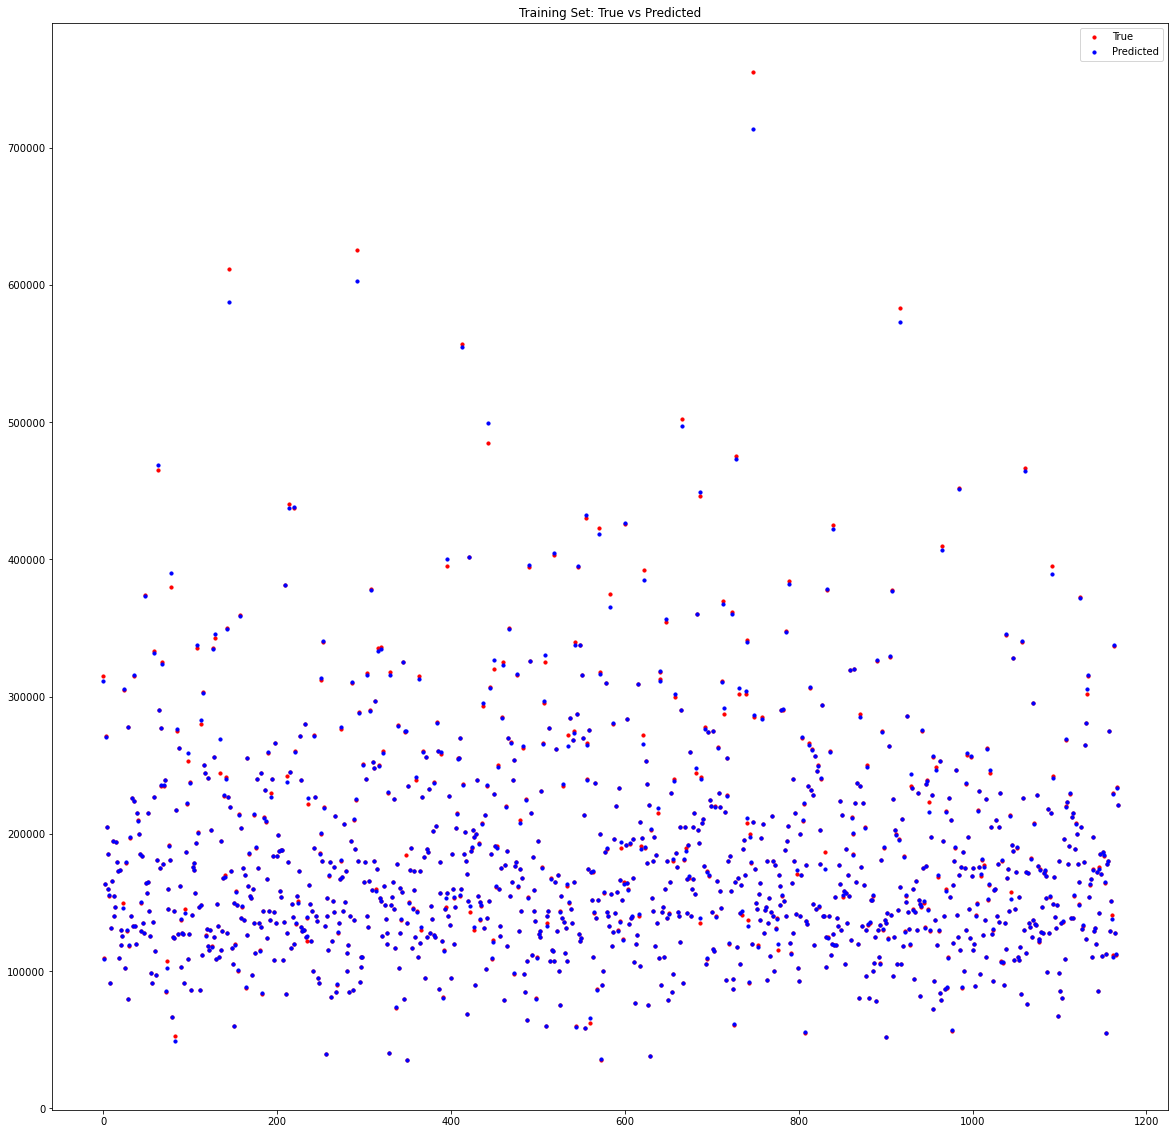

In [23]:
print("LightGBM Regressor Tuned") 
predicted_train_y = lgbm_best.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
PlotPrediction(train_y,predicted_train_y,"Training Set: ")

    Test Set
MSE: 826098627.1434315
MAE: 16380.57303874432
RMSE: 28741.93151379064
LogRMSE: 0.13194472260256582


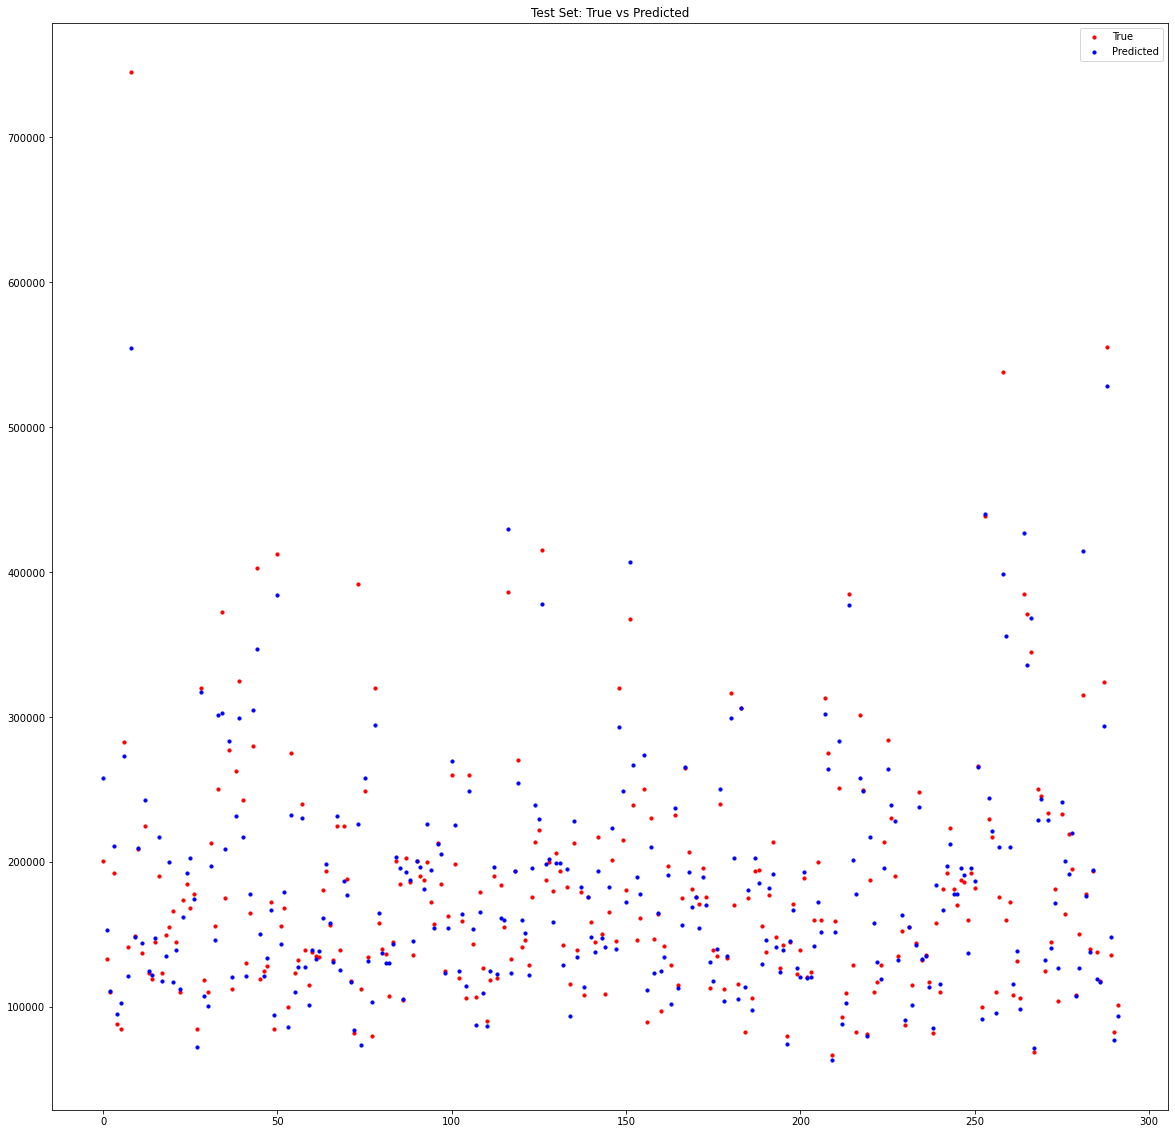

In [24]:
predicted_valid_y = lgbm_best.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
PlotPrediction(valid_y,predicted_valid_y,"Test Set: ")

<a id="Feature-Importance "></a>
## Feature Importance 

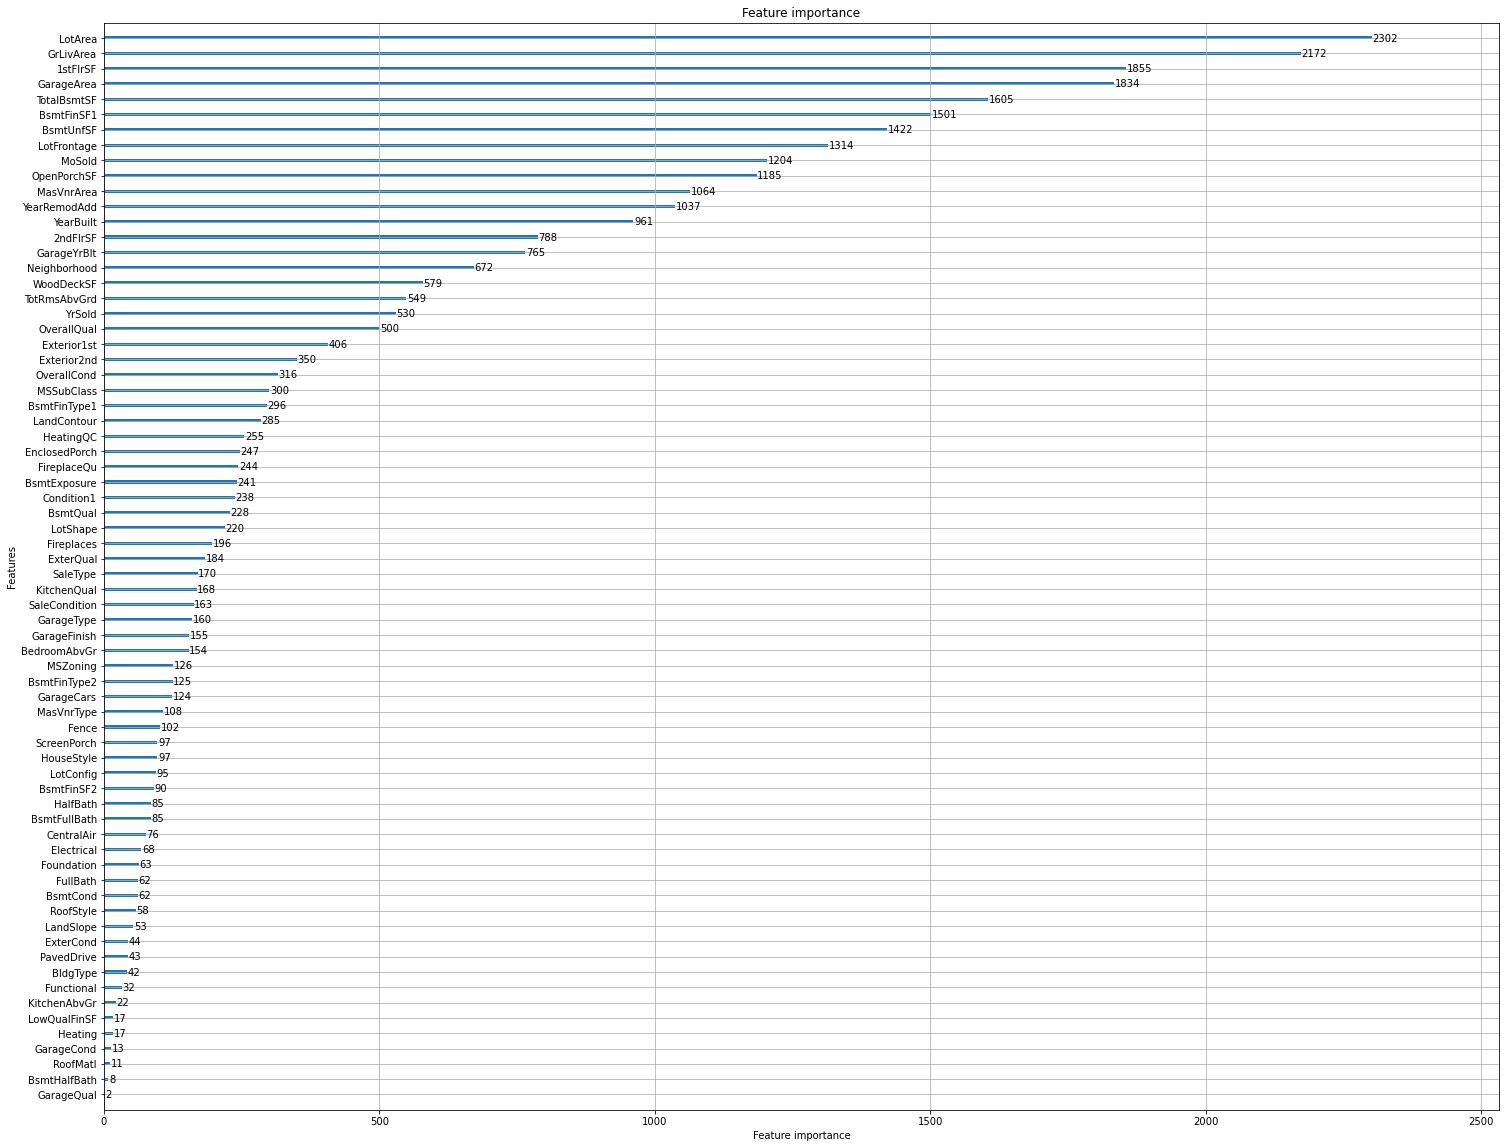

In [25]:
##% Feature Importance 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
lgb.plot_importance(lgbm_best,figsize=(25,20))

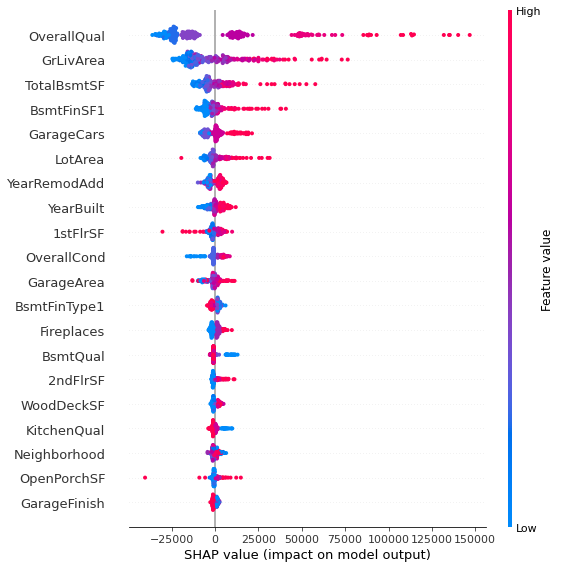

In [26]:
##% Feature Importance using shap package 
# import shap
lgbm_best.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(lgbm_best).shap_values(valid_X)
shap.summary_plot(shap_values, valid_X)

From both feature importance, we can see that **GrLivArea** and **LotArea** contributes a lot in prediction the price of home. The shap package is prefer when finding feature importance as it preservces consistency and accuracy. You can read more about the shap package in the links provided below:

[https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html)

[https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)  

[https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

<a id="Cross-Validation "></a>
## Cross Validation 

In [27]:
# Cross Validation with LightGBM

def K_Fold_LightGBM(X_train, y_train , cat_features, num_folds = 3):
    num = 0
    models = []
    folds = KFold(n_splits=num_folds, shuffle=True, random_state=0)

        # 5 times 
    for n_fold, (train_idx, valid_idx) in enumerate (folds.split(X_train, y_train)):
        print(f"     model{num}")
        train_X, train_y = X_train.iloc[train_idx], y_train.iloc[train_idx]
        valid_X, valid_y = X_train.iloc[valid_idx], y_train.iloc[valid_idx]
        
        train_data=lgb.Dataset(train_X,label=train_y, categorical_feature = cat_features,free_raw_data=False)
        valid_data=lgb.Dataset(valid_X,label=valid_y, categorical_feature = cat_features,free_raw_data=False)
        
        params_set = search_best_param(train_X,train_y,cat_features)
        
        CV_LGBM = lgb.train(params_set,
                            train_data,
                            num_boost_round = 2500,
                            valid_sets = valid_data,
                            early_stopping_rounds = 200,
                            verbose_eval = 100
                           )
        
        # increase early_stopping_rounds can lead to overfitting 
        models.append(CV_LGBM)
        
        print("Train set logRMSE:", mean_squared_error(np.log(train_y),np.log(models[num].predict(train_X)),squared = False))
        print(" Test set logRMSE:", mean_squared_error(np.log(valid_y),np.log(models[num].predict(valid_X)),squared = False))
        print("\n")
        num = num + 1
        
    return models

lgbm_models = K_Fold_LightGBM(X_train_clean_encoded,y,cat_features,5)

     model0
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 32378.7
[200]	valid_0's rmse: 31536.8
[300]	valid_0's rmse: 30597.5
[400]	valid_0's rmse: 29948.8
[500]	valid_0's rmse: 29428
[600]	valid_0's rmse: 29052.3
Did not meet early stopping. Best iteration is:
[687]	valid_0's rmse: 28741.9
Train set logRMSE: 0.013722985821368874
 Test set logRMSE: 0.13194472260256582


     model1
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 38526.5
[200]	valid_0's rmse: 26505
[300]	valid_0's rmse: 23225.1
[400]	valid_0's rmse: 22292.5
[500]	valid_0's rmse: 21836.8
[600]	valid_0's rmse: 21882.2
[700]	valid_0's rmse: 21970.4
Early stopping, best iteration is:
[506]	valid_0's rmse: 21835
Train set logRMSE: 0.08129809370230506
 Test set logRMSE: 0.11143477554934841


     model2
Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 48808.7
[200]	valid_0's rmse: 36655.6
[300]	valid_0's rmse: 33123.5


Train.csv 
MSE: 218262672.32835233
MAE: 7182.641146755161
RMSE: 14773.715589801786
LogRMSE: 0.06820524030775789


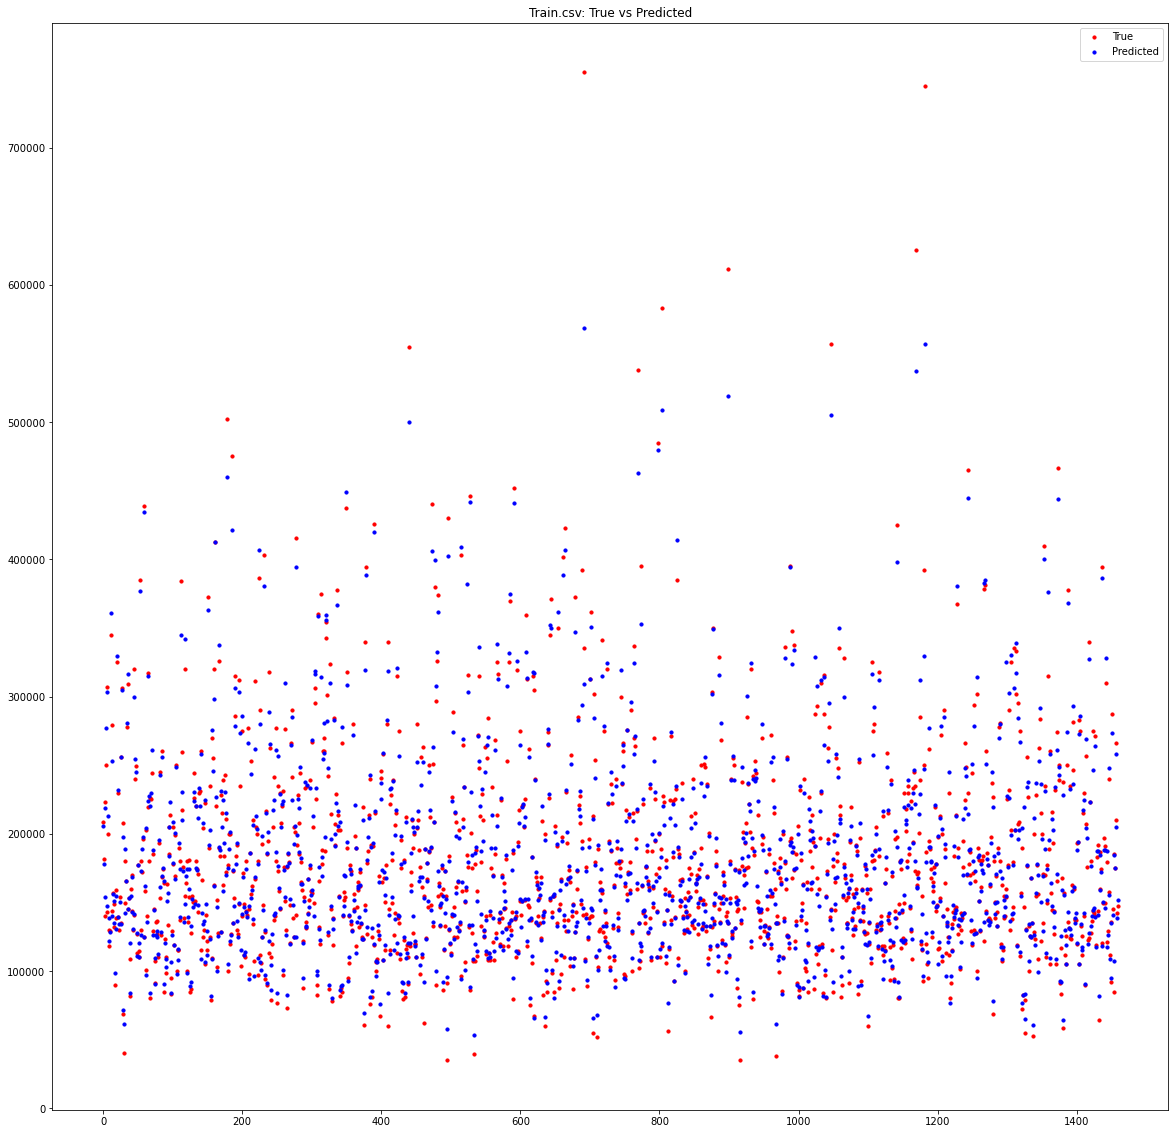

In [28]:
# Predict y_prds using models from cross validation 
def predict_cv(models_cv,X):
    y_preds = np.zeros(shape = X.shape[0])
    for model in models_cv:
        y_preds += model.predict(X)
        
    return y_preds/len(models_cv)

# evalute model using the entire dataset from Train.csv
evaluateRegressor(y,predict_cv(lgbm_models,X_train_clean_encoded),"Train.csv ")
PlotPrediction(y,predict_cv(lgbm_models,X_train_clean_encoded),"Train.csv: ")

<a id="Prediction-for-Test-Data"></a>
# Prediction for Test Data

In [29]:
predictLGBM = lgbm_best.predict(X_test_clean_encoded)
submissionLGBM = pd.DataFrame({'Id':test_Id,'SalePrice':predictLGBM})
display(submissionLGBM.head())

predictLGBM_CV = predict_cv(lgbm_models,X_test_clean_encoded)
submissionLGBM_CV = pd.DataFrame({'Id':test_Id,'SalePrice':predictLGBM_CV})
display(submissionLGBM_CV.head())

,Id,SalePrice
0,1461,120221.689503
1,1462,164123.611272
2,1463,182720.641109
3,1464,190709.592456
4,1465,184833.105947


,Id,SalePrice
0,1461,125094.101973
1,1462,156364.151248
2,1463,180356.425766
3,1464,187539.280032
4,1465,189460.746532


In [30]:
##% Submit Predictions 
submissionLGBM.to_csv('submissionLGBM4.csv',index=False)
submissionLGBM_CV.to_csv('submissionLGBM_CV4.csv',index=False)

<a id="Conclusion"></a>
# Conclusion

**Conclusion**
* LightGBM is a great ML algorithim that handles catagorical features and missing values 
* This is a great dataset to work on and lots of knowledge can be gain from withing with this dataset 
* Researching and reading other Kaggle notebooks is essential for becoming a better data scientist

**Challenges**
* This dataset had missing data so other imputation techniques could be used 
* Overfitting is an issue and might have occured
* No Data Visualization due to lots of features 

**Closing Remarks**  
* Please comment and like the notebook if it of use to you! Have a wonderful year! 

**Other Notebooks** 
* [https://www.kaggle.com/josephchan524/studentperformanceregressor-rmse-12-26-r2-0-26](https://www.kaggle.com/josephchan524/studentperformanceregressor-rmse-12-26-r2-0-26)
* [https://www.kaggle.com/josephchan524/bankchurnersclassifier-recall-97-accuracy-95](https://www.kaggle.com/josephchan524/bankchurnersclassifier-recall-97-accuracy-95)
* [https://www.kaggle.com/josephchan524/housepricesregressor-using-lightgbm](https://www.kaggle.com/josephchan524/housepricesregressor-using-lightgbm)
* [https://www.kaggle.com/josephchan524/tabularplaygroundregressor-using-lightgbm-feb2021](https://www.kaggle.com/josephchan524/tabularplaygroundregressor-using-lightgbm-feb2021)


2-12-2020
Joseph Chan 